# WORKFLOWS. DATA LIFE CYCLE
## AUTOR: Jesús Octavio Raboso
## GitHub: 

Los enunciados y resultados vistos en clase están en azul. El contenido de eñaboración propia está en negro.

# <font color='blue'>Workflow

<font color='blue'>En esta práctica vamos a aplicar lo aprendido en esta asignatura para crear un flujo que automatice la descarga, análisis y publicación de los datos utilizando distintas herramientas como Zenodo, github y librerías de python para el análisis de datos

### <font color='blue'>Librerías necesarias para la práctica

```python
import xml.etree.ElementTree as ET
import requests
import json
import zipfile
```

### <font color='blue'>Elementos necesarios</font>
* <font color='blue'>Al menos un fichero CSV</font>
* <font color='blue'>Un script de análisis de datos en CSV (Publicado en Github)</font>


# <font color='blue'>Publicación de datos iniciales</font>

<font color='blue'>Utilizando Zenodo, de forma manual, publicar los datos que se vayan a utilizar.</font>

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Utilizar Communities para localizar más facilmente los datos</p>
</div>


# <font color='blue'>Publicación de script de Análisis</font>

<font color='blue'>En Github + Zenodo</font>

# <font color='blue'>Descarga de datos</font>

<font color='blue'>Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)</font>

<font color='blue'>Pista: url+'?verb=ListRecords&set=nombre_set</font>

In [1]:
import requests
import json
import csv
from datetime import datetime
import xml.etree.cElementTree as ET
import os

<font color='blue'>Un par de funciones para búsqueda</font>

In [2]:
def search_dataset(url, oai_set, metadata_format):
    """Search the datasets identifiers in the defined set
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        oai_set : string
            OAI-PMH set where the datasets will be searched
        metadata_format : string
            Selected metadata format to search
        Returns
        -------
        dataset_ids : array 
            Dataset IDs
    """
    #Define bounds to search in specific set
    bounds = "&set="+oai_set
    print(url+'?verb=ListRecords&metadataPrefix='+metadata_format+bounds)
    oai = requests.get(url+'?verb=ListRecords&metadataPrefix='+metadata_format+bounds)

    oaiTree = ET.ElementTree(ET.fromstring(oai.text.encode('utf-8')))
    item = oaiTree.findall('.//{http://datacite.org/schema/kernel-3}identifier')
    return item

In [3]:
def get_oai_metadata_formats(url):
    """Lists the available metadata formats
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        Returns
        -------
        metadata_formats : 
            Name of the downloaded file(s).
    """
    metadata_formats = []
    oai_verb = '?verb=ListMetadataFormats'
    oai = requests.get(url + oai_verb) #Peticion al servidor
    xmlTree = ET.ElementTree(ET.fromstring(oai.text))
    iterator = xmlTree.iter()
    for elem in iterator:
        if (elem.tag == '{http://www.openarchives.org/OAI/2.0/}metadataPrefix'):
            metadata_formats.append(elem.text)
    return metadata_formats

In [4]:
def check_dataset(ids,api_url,tipo):
    """Checks if the available datasets satisfy the dates and location req
        Parameters
        ----------
        ids : array
            List of dataset ids
        api_url : string
            API to get dataset metadata
        tipo : string
            type of file to download
        Returns
        -------
        downloaded_datasets : array 
            List of downloaded datasets
    """
    file_list = []
    for i in ids:
        headers = {'accept': 'application/json'}
        #TODO Manage different types of identifiers (i.text.replace('record', 'api/records'),headers))
        r = requests.get('https://doi.org/'+i.text,headers)
        r = requests.get(r.url.replace('record', 'api/records'),headers)
        for u in r.json()['files']:
            print("Type found: %s" % u['type'])
            if u['type'] == tipo:
                print(u['links']['self'])
                link = u['links']['self']
                file_name = u["key"].replace('/','_')
                with open(file_name, "wb") as f:
                    print("Downloading %s" % file_name)
                    response = requests.get(link, stream=True)
                    total_length = response.headers.get('content-length')

                    if total_length is None: # no content length header
                        f.write(response.content)
                    else:
                        dl = 0
                        total_length = int(total_length)
                        for data in response.iter_content(chunk_size=4096):
                            dl += len(data)
                            f.write(data)
                            done = int(50 * dl / total_length)
                            sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                            sys.stdout.flush()
                file_list.append(file_name)
                print("Download complete")     
                                
    return file_list

<font color='blue'>Busco el dataset</font>

In [5]:
import sys
#Searching datasets OAI-PMH
print("Searching datasets OAI-PMH")
oai_url = 'https://zenodo.org/oai2d'
metadata_formats = get_oai_metadata_formats(oai_url)

#TODO hardcoded
print("Searching Datasets")
oai_set = 'user-cdp'
dataset_list = search_dataset(oai_url,oai_set,'oai_datacite3')
print(dataset_list)

print("Checking/download Datasets")
api_url = 'https://doi.org/'

csv_files = check_dataset(dataset_list,api_url,'csv')
print(csv_files)

Searching datasets OAI-PMH
Searching Datasets
https://zenodo.org/oai2d?verb=ListRecords&metadataPrefix=oai_datacite3&set=user-cdp
[<Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd58c50c9b0>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd58c50def0>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd58c513230>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd58c51a470>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd58c51d6b0>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd58c521890>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd58c5258f0>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd58c07f110>]
Checking/download Datasets
Type found: zip
Type found: xml
Type found: xml
Type found: xml
Type found: xml
Type found: nc
Type found: csv
https://zenodo.org/api/files/73f3573e-3dd9-48af-bca1-2e3948baeb2c/amt_2010.csv
Download complete
Ty

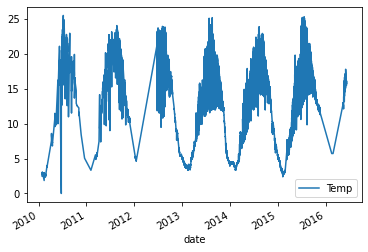

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('amt_2010.csv',delimiter=';')
data['date'] = pd.to_datetime(data['date'])
data.plot(x='date', y='Temp')
plt.show()

In [7]:
ls

amt_2010.csv  GuionPractica_Zenodo.ipynb        my_problem.py
analysis.png  M3.02Workflow_resuelto2022.ipynb  plot.py


Number of arguments: 2 arguments
Argument List:['plot.py', 'amt_2010.csv']


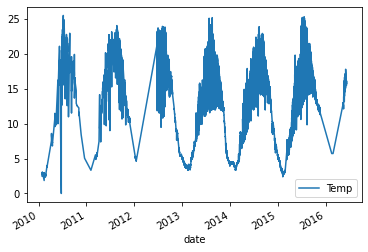

In [8]:
%run -i plot.py amt_2010.csv

# <font color='blue'>Descarga de código</font>

<font color='blue'>Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)</font>

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Zenodo guarda un zip con el código</p>
</div>

In [9]:
 #Searching code OAI-PMH
print("Searching software OAI-PMH")
oai_url = 'https://zenodo.org/oai2d'
metadata_formats = get_oai_metadata_formats(oai_url)

#TODO hardcoded
print("Searching Software")
oai_set = 'user-cdp'
dataset_list = search_dataset(oai_url,oai_set,'oai_datacite')
print(dataset_list)

print("Checking/download Datasets")
api_url = 'https://doi.org/'

zip_files = check_dataset(dataset_list,api_url,'zip')
print(zip_files)

Searching software OAI-PMH
Searching Software
https://zenodo.org/oai2d?verb=ListRecords&metadataPrefix=oai_datacite&set=user-cdp
[<Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd550803110>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd550802650>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd550801950>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd5507ffa10>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd5507fec50>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd5507fbe30>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd5507f7e90>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd5511706b0>]
Checking/download Datasets
Type found: zip
https://zenodo.org/api/files/eb080151-e76f-4523-99fc-c2bc8638115c/ferag/csvprinter-1.01.zip
[==================================================]Download complete
Type found: xml
Type found: xml
T

In [10]:
import zipfile
with zipfile.ZipFile("ferag_csvprinter-1.01.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [11]:
ls ferag-csvprinter-59552e7

plot.py  README.md


# <font color='blue'>Análisis de los datos</font>

<font color='blue'>Producir fichero: Otro CSV, imagen, etc</font>

Number of arguments: 2 arguments
Argument List:['ferag-csvprinter-59552e7/plot.py', 'amt_2010.csv']


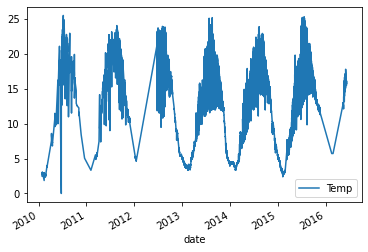

In [12]:
# Saves plot @ ferag-csvprinter-59552e7
%run -i ferag-csvprinter-59552e7/plot.py amt_2010.csv

# <font color='blue'>Publicación de los Datos</font>

<font color='blue'>Utilizando la API de Zenodo</font>

In [13]:
ACCESS_TOKEN = 'p6fKXiwn7ABPVLC2Y85b1rUOwso46jHpTbPzXY97DxZB4x4cHUv65JJQkvVy'
r = requests.get('https://zenodo.org/api/deposit/depositions',params={'access_token': ACCESS_TOKEN})
r.status_code  
r.json()

[{'conceptrecid': '1442720',
  'created': '2018-10-02T13:15:30.984794',
  'doi': '',
  'doi_url': 'https://doi.org/',
  'files': [{'checksum': 'af0b4a4bbe3930b0ea61538bca6497f2',
    'filename': 'electricom.png',
    'filesize': 315,
    'id': '9dfa096d-489d-4059-be91-5a782c9841d9',
    'links': {'download': 'https://zenodo.org/api/files/a33cf662-1d2d-4e7b-97a3-3d4c0a15dded/electricom.png',
     'self': 'https://zenodo.org/api/deposit/depositions/1442721/files/9dfa096d-489d-4059-be91-5a782c9841d9'}}],
  'id': 1442721,
  'links': {'bucket': 'https://zenodo.org/api/files/a33cf662-1d2d-4e7b-97a3-3d4c0a15dded',
   'discard': 'https://zenodo.org/api/deposit/depositions/1442721/actions/discard',
   'edit': 'https://zenodo.org/api/deposit/depositions/1442721/actions/edit',
   'files': 'https://zenodo.org/api/deposit/depositions/1442721/files',
   'html': 'https://zenodo.org/deposit/1442721',
   'latest_draft': 'https://zenodo.org/api/deposit/depositions/1442721',
   'latest_draft_html': 'http

In [14]:
deposition_id = "1442721"
data = {'name': 'electricom.png'}
files = {'file': open('plot.py', 'rb')}
r = requests.post('https://zenodo.org/api/deposit/depositions/%s/files' % deposition_id,
                  params={'access_token': ACCESS_TOKEN}, data=data,
                  files=files)
r.status_code

400

In [15]:
data = {
    'metadata': {
        'title': 'My first upload',
        'upload_type': 'poster',
        'description': 'This is my first upload',
        'creators': [{'name': 'Doe, John',
                      'affiliation': 'CSIC'}]
    }
}

headers = {'accept': 'application/json'}
r = requests.put('https://zenodo.org/api/deposit/depositions/%s' % deposition_id,
                 params={'access_token': ACCESS_TOKEN}, data=json.dumps(data),
                 headers=headers)
r.status_code

415

In [16]:
r.json()

{'status': 415, 'message': 'Unsupported media type "".'}

# INICIO EJERCICIO PERSONAL.

En Zenodo, ehmos creado la comunidad https://zenodo.org/communities/jordlc/ Visítese en enlace para ver su contenido. En dicha comunidad hemos subido los archivos que vamos a necesitar. 

BiciMAD es un medio de transporte público de la ciudad de Madrid de bicicletas eléctricas. Su objetivo es proporcionar un elemento alternativo de transporte limpio y saludable al ciudadano y fomentar el uso de la bicicleta en la ciudad.

A día de hoy, posee 2964 bicicletas, 6315 anclajes y 264 estaciones. 

BiciMAD destaca por el empleo de las TIC y la Comunicación para mejorar la experiencia del usuario. Dispone de información en tiempo real de bicicletas y estaciones dispobibles, acceso a la propia base de datos, web... 

Para más información sobre BiciMAD, puede consultarse: https://www.bicimad.com/


En el portal de datos en abierto del ayuntamiento de Madrid, https://datos.madrid.es/portal/site/egob, pueden encontrarse múltiples datasets relativos al servicio de BiciMAD que abordan que recogen la posición geográfica de los anclajes, los datos de losviajes desglosados por meses, años, ....

Para más información sobre el contenido de los datsaets: https://opendata.emtmadrid.es/Documentos/Servicios-y-estructuras-Bicimad-V1-1.aspx. 


Las siguientes celdas, son parte de un estudio realizado por Elisa Casado Gómez, Aurora Ruiz de la Puente, Clara Perez Martín, Elisa Saiz y Jesús Octavio Raboso. Puede encontrarse al completo en 

# https://github.com/Jesus-Octavio/BiciMAD

En él, se recogían datos desde Julio de 2018 hasta Junio de 2019. Además, también se abordaba desde un punto de vista geográfico, pues se dispone de datasets con las localizaciones de los anclajes o estaciones. Posteriormente abordaremos una selección de dichos datasets de manera más detallada. 


En primer lugar, sin tener en cuenta datos de tipo geográfico, se hizo el siguiente análisis.
* Computo total de viajes por mes. 
* Análisis de tipo de usuario por mes. BiciMAD establece 4 tipos de usuario (numerados del 0 al 3). Los usuarios de tipo 0, son aquellos que no tienen tipo definido; los de tipo 1 son aquellos que poseen un abono anual; los de tipo 2 son aquellos ocasionales; los de tipo 3 son trabajadores de BiciMAD: 
* Para registratse en BiciMAD es neceario poner un código postal, de modo que se realizaba un análisis de usuarios según el código postal de registro para ver la procendencia de dichos usuarios. ¿Son todos de Madrid? ¿Qué comunidad autónoma que no sea Madrid posee más usuarios de BiciMAD ?
* Usuarios según rango de edad.
* Distribución de los viajes en función de la hora y el día de la semana. 


A partir de este análisis se escogían dos meses: aquel en el que había más viajes (Junio de 2019) y el de menos viajes (Diciembre de 2018)

Seleccionados estos meses, se realizaba un análisis más profundo que consideraba las posiciones geográficas de las bicicletas y estaciones:

* Para el peor y el mejor mes, duración media de los trayecto.
* Para el peor y el mejor mes, estaciones de destino más habituales.
* Para el peor y el mejor mes, estaciones de origen más habituales.
* Para el peor y el mejor mes, número de trayectos cuya estación de origen está en el mismo barrio que la estación de destino.
* Para el peor y el mejor mes,  número de viajes cuya estación de origen está en un barrio distinto a la estación de destino.
* Mapas con `folium`. Para el peor y el mejor mes:
    * Duración media de trayectos según estación de origen.
    * Ranking de estaciones más visitadas.
    * Viajes por barrio.
* Grafos y algoritmo de Floyd. Análisis de trayectos mediante grafos e implementación del algoritmo de Floys para, dadas la estación de origen y destino, devolver la ruta más rápida. 



### Buscamos los dataset en Zenodo:

Hemos creado la comunidad https://zenodo.org/communities/jordlc/ en la que simplemente he subido el dataset del mejor mes (201906_Usage_Bicimad.json) y el dataset del peor mes (201812_Usage_Bicimad.json). También están subidos los datos de las bases/estaciones/anclajes en dichos meses (Bicimad_Stations_201906.json , Bicimad_Stations_201812.json) y los datos geográficos de las mismas (bases_bicimad.csv, bases_bicimad.xlsx)


Puesto que el objetico de esta práctica no es el de analizar los datos de BiciMAD, seleccionaré un par de gráficas y problemas interesantes para realizar lo que se pide. 


**Harvesting URL:**

https://zenodo.org/oai2d?verb=ListRecords&set=user-jordlc&metadataPrefix=oai_dc

Above address links to a OAI-PMH feed, which can be used by other digital repositories to harvest this community.


In [17]:
import sys
#Searching datasets OAI-PMH
print("Searching datasets OAI-PMH")
oai_url = 'https://zenodo.org/oai2d'
metadata_formats = get_oai_metadata_formats(oai_url)

Searching datasets OAI-PMH


In [18]:
#TODO hardcoded
print("Searching Datasets")
oai_set = 'user-jordlc'
dataset_list = search_dataset(oai_url,oai_set,'oai_datacite3')
#dataset_list = search_dataset(oai_url,oai_set,'oai_')
print(dataset_list)

Searching Datasets
https://zenodo.org/oai2d?verb=ListRecords&metadataPrefix=oai_datacite3&set=user-jordlc
[<Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd56799d770>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd56799fa70>]


In [19]:
print("Checking/download Datasets")
api_url = 'https://doi.org/'

csv_files = check_dataset(dataset_list,api_url,'csv')
print(csv_files)

Checking/download Datasets
Type found: json
Type found: json
Type found: csv
https://zenodo.org/api/files/3daacf84-af1d-47ad-8f65-4c69cff42723/bases_bicimad.csv
Download complete
Type found: xlsx
Type found: json
Type found: json
Type found: zip
['bases_bicimad.csv']


In [20]:
json_files = check_dataset(dataset_list,api_url,'json')
print(json_files)

Type found: json
https://zenodo.org/api/files/3daacf84-af1d-47ad-8f65-4c69cff42723/201812_Usage_Bicimad.json
Download complete
Type found: json
https://zenodo.org/api/files/3daacf84-af1d-47ad-8f65-4c69cff42723/201906_Usage_Bicimad.json
Download complete
Type found: csv
Type found: xlsx
Type found: json
https://zenodo.org/api/files/3daacf84-af1d-47ad-8f65-4c69cff42723/Bicimad_Stations_201812.json
Download complete
Type found: json
https://zenodo.org/api/files/3daacf84-af1d-47ad-8f65-4c69cff42723/Bicimad_Stations_201906.json
Download complete
Type found: zip
['201812_Usage_Bicimad.json', '201906_Usage_Bicimad.json', 'Bicimad_Stations_201812.json', 'Bicimad_Stations_201906.json']


In [21]:
xlsx_files = check_dataset(dataset_list,api_url,'xlsx')
print(xlsx_files)

Type found: json
Type found: json
Type found: csv
Type found: xlsx
https://zenodo.org/api/files/3daacf84-af1d-47ad-8f65-4c69cff42723/bases_bicimad.xlsx
[==================================================]Download complete
Type found: json
Type found: json
Type found: zip
['bases_bicimad.xlsx']


## ANÁLISIS DE DATOS

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

from pyspark import SparkContext
import json

sc = SparkContext()

22/02/07 10:31:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Leemos las rdds del mejor y peor mes de acuerdo a los resultados obtenidos en la parte anterior para los viajes filtrados, pues sólo nos interesa trabajar con los viajes que hemos considerado válidos. El peor mes es diciembre de 2018 y el mejor mes es junio de 2019.

In [23]:
rdd_worst = sc.textFile('201812_Usage_Bicimad.json')
rdd_best = sc.textFile('201906_Usage_Bicimad.json')

Definimos un mapper, que aplicaremos a la hora de leer los archivos json relativos al peor y mejor mes, para quedarnos únicamente con los datos que van a ser necesarios:

    Estación de origen
    Estación de destino
    Tiempo de viaje



In [24]:
def mapper(line):
    data = json.loads(line)
    origin = data['idunplug_station']
    destination = data['idplug_station']
    travel_time = data['travel_time']
    return origin, destination, travel_time

Filtramos los viajes por aquellos que duran más de 30 segundos y sus estaciones de origen y destino son distintas. Cada elemento de las rdd rdd_worst_filtered (para el peor mes) y rdd_best_filtered (para el mejor mes) será de la forma:


  *(estacion de origen, estacion de destino, tiempo de viaje en segundos)*

In [25]:
rdd_worst_filtered = rdd_worst.map(mapper).\
                     filter(lambda x: x[0]!=x[1] and x[2]>30)

rdd_best_filtered = rdd_best.map(mapper).\
                    filter(lambda x: x[0]!=x[1] and x[2]>30)

A continuación, vamos a desarollar distintos problemas para el mejor y peor mes considerados. Primero calcularemos los datos que nos interesan y después vamos a crear mapas en los que visualizaremos la información de una forma más interactiva.

### PROBLEMA 1: DURACIÓN MEDIA DE LOS VIAJES



Vamos a calcular la duración media de los viajes que parten de una estación. Recordamos que el tiempo se guarda en segundos.

En primer lugar, lo hacemos para el peor mes.

* Creamos un diccionario en el que las claves son las estaciones de origen y el valor, las veces que aparece en la rdd de viajes filtrados. Es decir, el número de viajes que parten de ella. Será relevente para calcular el tiempo medio.
* Nos quedamos con la estación de origen y el tiempo de cada viaje, los reducimos según la clave mediante la suma de valores. Hallamos la media. Los ordenamos según el número de estacion de menor a mayor.



In [26]:
dict_worst = dict(rdd_worst_filtered.map(lambda x: (x[0], x[2])).\
                              countByKey())

rdd_average_time_worst = rdd_worst_filtered.map(lambda x: (x[0],x[2])).\
                        reduceByKey(lambda x,y: x+y).\
                        map(lambda x: (x[0], x[1]/dict_worst[x[0]])).\
                        sortByKey()

rdd_average_time_worst.take(5) #Para visualizar cómo quedan los datos

[(1, 2392.098510882016),
 (2, 4149.476772616137),
 (3, 1018.5118811881188),
 (4, 1059.5748829953197),
 (5, 973.8588235294118)]

Repetimos con el mejor mes.

In [27]:
dict_best = dict(rdd_best_filtered.map(lambda x: (x[0], x[2])).\
                              countByKey())

rdd_average_time_best = rdd_best_filtered.map(lambda x: (x[0],x[2])).\
                        reduceByKey(lambda x,y: x+y).\
                        map(lambda x: (x[0], x[1]/dict_best[x[0]])).\
                        sortByKey()

rdd_average_time_best.take(5)

[(1, 845.8831627250265),
 (2, 996.0376794258373),
 (3, 906.6870662460568),
 (4, 836.7305825242719),
 (5, 935.4925458715596)]

Guardamos la diferencia:

In [28]:
rdd_average_time_comp = rdd_average_time_best.join(rdd_average_time_worst).sortByKey().map(lambda x: (x[0], x[1][0], x[1][1], x[1][0]-x[1][1]))
rdd_average_time_comp.take(5)

[(1, 845.8831627250265, 2392.098510882016, -1546.2153481569894),
 (2, 996.0376794258373, 4149.476772616137, -3153.4390931903),
 (3, 906.6870662460568, 1018.5118811881188, -111.82481494206195),
 (4, 836.7305825242719, 1059.5748829953197, -222.84430047104786),
 (5, 935.4925458715596, 973.8588235294118, -38.36627765785215)]

Para hacer mejor un análisis de los datos lo que hacemos es representar los valores obtenidos en una gráfica. Para ello, lo primero que hacemos es crear un Data Frame y un Panda para poder obtener las columnas y hacer la gráfica comparativa.

In [29]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [30]:
dft = spark.createDataFrame(rdd_average_time_comp, schema = ['Station number', 'Average travel time best month','Average travel time worst month', 'Difference best month-worst month' ])
pt = dft.toPandas()

In [31]:
pt.head()

,Station number,Average travel time best month,Average travel time worst month,Difference best month-worst month
0,1,845.883163,2392.098511,-1546.215348
1,2,996.037679,4149.476773,-3153.439093
2,3,906.687066,1018.511881,-111.824815
3,4,836.730583,1059.574883,-222.844300
4,5,935.492546,973.858824,-38.366278


In [32]:
stations = list(pt.iloc[:,0])
bm = list(pt.iloc[:,1]) #best month
wm = list(pt.iloc[:,2]) #worst month
d = list(pt.iloc[:,3]) #difference

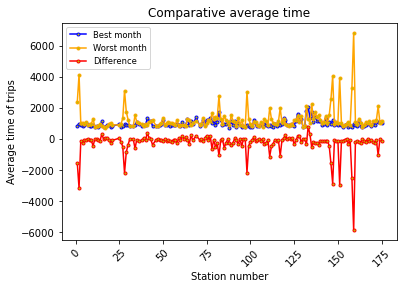

In [33]:
p1 = plot(stations, bm,c='b',label='Best month',mfc='y',ls='-',marker='.')
p2 = plot(stations, wm,c='orange',label='Worst month',mfc='y',ls='-',marker='.')
p3 = plot(stations, d,c='r',label='Difference',mfc='y',ls='-',marker='.')
xlabel("Station number")
ylabel("Average time of trips")
legend(loc='best', fontsize = 'small')
title('Comparative average time')
plt.xticks(rotation=45)
plt.rcParams["figure.figsize"] = [16,9] #Ejecutar dos veces para obtener este tamaño
plt.savefig("analysis.png")
show()

En la gráfica podemos observar que salvo en algunas estaciones, la diferencia está en torno al 0, por lo tanto, podemos deducir que, en general, no hay diferencias significativas en el tiempo medio de viajes en los dos meses que estamos analizando.

El mejor mes, es el que más viajes tiene, por lo tanto, la media de sus viajes era esperable que fuese más lineal ya que tenemos más datos para realizar una mejor media.


### PROBLEMA 2. ESTACIONES DE DESTINO

Para cada estación, vamos a hallar las 5 estaciones más frecuentes a las 
que se llega desde un viaje iniciado en la estación considerada.



En primer lugar, lo hacemos para el **peor mes**.


Hacemos un map para quedarnos únicamente con tuplas de la forma *(estacion de origen, estacion de destino)*.

Agrupamos por claves y contamos cuántas veces se repite cada elemento en la segunda componente de la tupla gracias a Counter. Tenemos tuplas en las que la primera componente son las estaciones de origen y la segunda, diccionarios en los que la clave son las estaciones de destino y el valor, la frecuencia con la que aparecen, es decir, cuántos viajes llegan a ella desde la estación de origen.

Los ordenamos según la clave.

Ordenamos la segunda componente de la tupla, que es un diccionario, en orden decreciente según los valores. Nos quedamos con los cinco primeros.

El resultado final es una lista de tuplas de la forma: 
[(estación de origen, [(estación de destino, viajes entre origen y destino)])]




In [34]:
from collections import Counter

rdd_trips_worst_destinations = rdd_worst_filtered.map(lambda x: (x[0], x[1])).\
                  groupByKey().mapValues(Counter).\
                  sortByKey().\
                  mapValues(lambda y: sorted(y.items(), key=lambda z: z[1], reverse = True)).\
                  mapValues(lambda y: y[:5])


rdd_trips_worst_destinations.take(1)

[(1, [(175, 43), (91, 27), (41, 20), (72, 19), (49, 18)])]

Repetimos para el **mejor mes**.

In [35]:
rdd_trips_best_destinations = rdd_best_filtered.map(lambda x: (x[0], x[1])).\
                  groupByKey().mapValues(Counter).\
                  sortByKey().\
                  mapValues(lambda y: sorted(y.items(), key=lambda z: z[1], reverse = True)).\
                  mapValues(lambda y: y[:5])


rdd_trips_best_destinations.take(1)

[(1, [(175, 116), (41, 93), (49, 63), (57, 60), (133, 56)])]

Como podemos ver, desde la estación 1 se repiten tres estaciones entre las más frecuentes de llegada en el mejor y el peor: la 175, la 41 y la 49. 

Para comparar las estaciones de destino más frecuentes, vamos a calcular para cada estación, cuantas estaciones de llegada más frecuentes se repiten en el mejor y en el peor mes. Vamos a calcular los porcentajes de estaciones en las que se repiten como destinos más frecuentes una estación, dos, tres, cuatro, o todas, en los meses con más y con menos viajes.

In [36]:
rdd_both_dest = rdd_trips_worst_destinations.union(rdd_trips_best_destinations).map(lambda x: (x[0],[x[1][0][0],x[1][1][0],x[1][2][0],x[1][3][0],x[1][4][0]])).reduceByKey(lambda x,y:x+y).\
           map(lambda x:(x[0],len(set(x[1]))) )
total_stations_dest = rdd_both_dest.count() #total number of stations

In [37]:
one_station_repeat_dest = rdd_both_dest.filter(lambda x: x[1]==9).count()
percentage_one_station_repeated_dest = (one_station_repeat_dest/total_stations_dest)*100

In [38]:
two_station_repeat_dest = rdd_both_dest.filter(lambda x: x[1]==8).count()
percentage_two_station_repeated_dest = (two_station_repeat_dest/total_stations_dest)*100


In [39]:
three_station_repeat_dest = rdd_both_dest.filter(lambda x: x[1]==7).count()
percentage_three_station_repeated_dest = (three_station_repeat_dest/total_stations_dest)*100

In [40]:
four_station_repeat_dest = rdd_both_dest.filter(lambda x: x[1]==6).count()
percentage_four_station_repeated_dest = (four_station_repeat_dest/total_stations_dest)*100

In [41]:
five_station_repeat_dest = rdd_both_dest.filter(lambda x: x[1]==5).count()
percentage_five_station_repeated_dest = (five_station_repeat_dest/total_stations_dest)*100

In [42]:
zero_station_repeat_dest = rdd_both_dest.filter(lambda x: x[1]==10).count()
percentage_zero_station_repeated_dest = (zero_station_repeat_dest/total_stations_dest)*100

In [43]:
repeated_stations_dest = {'0 common station repeated' : [percentage_zero_station_repeated_dest], '1 common station repeated': [percentage_one_station_repeated_dest], '2 common station repeated': [percentage_two_station_repeated_dest], '3 common station repeated': [percentage_three_station_repeated_dest], '4 common station repeated': [percentage_four_station_repeated_dest], '5 common station repeated': [percentage_five_station_repeated_dest]}
tabla_repeated_stations_dest = pd.DataFrame(repeated_stations_dest)
tabla_repeated_stations_dest

,0 common station repeated,1 common station repeated,2 common station repeated,3 common station repeated,4 common station repeated,5 common station repeated
0,2.777778,20.555556,36.666667,25.0,7.222222,7.777778


Lo que podemos ver es que, para más del 97% de las estaciones, se repite alguna estación de destino más frecuente en el mes con más y con menos viajes. En casi el 8% de las estaciones, los destinos más frecuentes coinciden por completo en el mejor y el peor mes. 

Quedémosnos con el **problema 1: duración media de los viajes**. Creamos un archivo `my_problem.py` para obtener la gráfica anteriormente mosttrada.

In [44]:
# Close previous spark context
sc.stop()

Number of arguments: 3 arguments
Argument List:['my_problem.py', '201812_Usage_Bicimad.json', '201906_Usage_Bicimad.json']
201812_Usage_Bicimad.json
201906_Usage_Bicimad.json


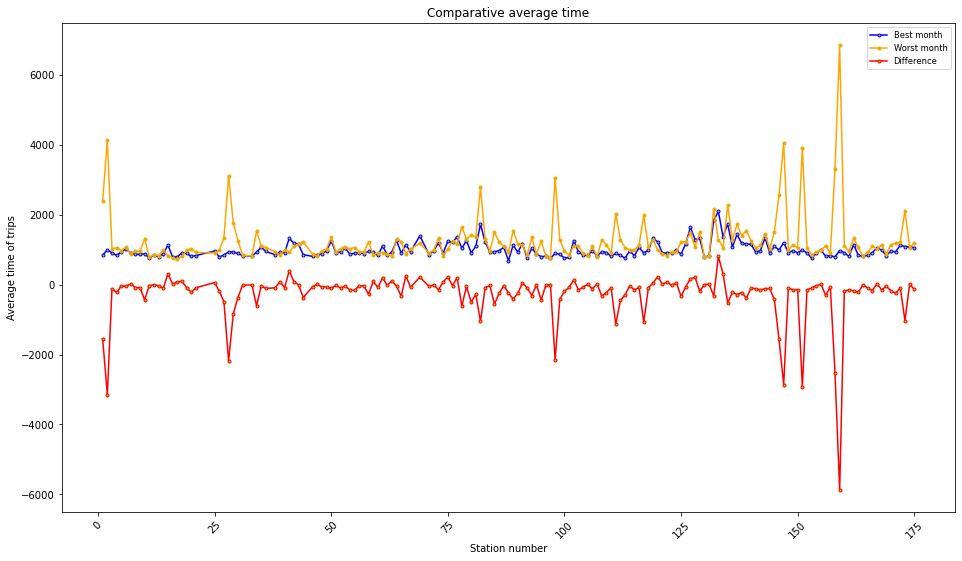

In [45]:
%run -i my_problem.py 201812_Usage_Bicimad.json 201906_Usage_Bicimad.json

In [46]:
 #Searching code OAI-PMH
print("Searching software OAI-PMH")
oai_url = 'https://zenodo.org/oai2d'
metadata_formats = get_oai_metadata_formats(oai_url)

#TODO hardcoded
print("Searching Software")
oai_set = 'user-jordlc'
dataset_list = search_dataset(oai_url,oai_set,'oai_datacite')
print(dataset_list)

print("Checking/download Datasets")
api_url = 'https://doi.org/'

zip_files = check_dataset(dataset_list,api_url,'zip')
print(zip_files)

Searching software OAI-PMH
Searching Software
https://zenodo.org/oai2d?verb=ListRecords&metadataPrefix=oai_datacite&set=user-jordlc
[<Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd5675c3bf0>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x7fd5675d4710>]
Checking/download Datasets
Type found: json
Type found: json
Type found: csv
Type found: xlsx
Type found: json
Type found: json
Type found: zip
https://zenodo.org/api/files/314712e0-2299-48e3-aa23-58413ba50224/dlczip.zip
[==================================================]Download complete
['dlczip.zip']


In [47]:
import zipfile
with zipfile.ZipFile("dlczip.zip","r") as zip_ref:
    zip_ref.extractall(path = "/home/jesus/Escritorio/dlc/dlc_extract")

In [48]:
ls "/home/jesus/Escritorio/dlc/dlc_extract"

dlczip/


In [49]:
ls "/home/jesus/Escritorio/dlc/dlc_extract/dlczip"

201812_Usage_Bicimad.json  201906_Usage_Bicimad.json  my_problem.py


# Análisis de los datos


In [50]:
sc.stop()

Number of arguments: 3 arguments
Argument List:['/home/jesus/Escritorio/dlc/dlc_extract/dlczip/my_problem.py', '201812_Usage_Bicimad.json', '201906_Usage_Bicimad.json']
201812_Usage_Bicimad.json
201906_Usage_Bicimad.json


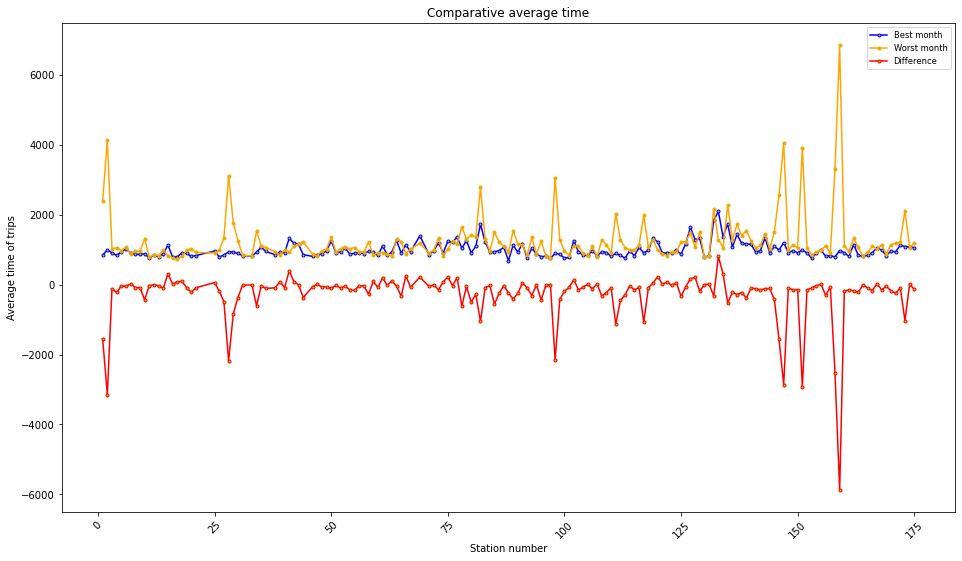

In [51]:
%run -i /home/jesus/Escritorio/dlc/dlc_extract/dlczip/my_problem.py 201812_Usage_Bicimad.json 201906_Usage_Bicimad.json

En la gráfica podemos observar que salvo en algunas estaciones, la diferencia está en torno al 0, por lo tanto, podemos deducir que, en general, no hay diferencias significativas en el tiempo medio de viajes en los dos meses que estamos analizando.

El mejor mes, es el que más viajes tiene, por lo tanto, la media de sus viajes era esperable que fuese más lineal ya que tenemos más datos para realizar una mejor media. Además, se trata de un mes de verano así que es probable que muchos usuarios simplememte usen BiciMAD por la gracia de ir en bicicleta eleéctrica. 


### Publicación de los datos:

In [52]:
ACCESS_TOKEN = 'bCgiBtkjMjoA4zGpwUHbINltt8aNefVcSHKowt4SUGGPsQLuNu1vBSgn76Ln'
connection = requests.get('https://zenodo.org/api/deposit/depositions',params={'access_token': ACCESS_TOKEN})
connection.status_code  

200

In [53]:
connection = connection.json()

In [54]:
i = 0
for elem in connection:
    print("NEW ELEMENT FOUND")
    print(elem)
    print("\n")
    i = i+1

NEW ELEMENT FOUND
{'conceptdoi': '10.5281/zenodo.5992966', 'conceptrecid': '5992966', 'created': '2022-02-07T08:48:04.063485', 'doi': '10.5281/zenodo.5992967', 'doi_url': 'https://doi.org/10.5281/zenodo.5992967', 'files': [{'checksum': 'f377659bf58fd1d4a3da355f01167d7b', 'filename': 'dlczip.zip', 'filesize': 134432785, 'id': '6753915f-3280-401f-a8c4-e6a6678c5955', 'links': {'download': 'https://zenodo.org/api/files/314712e0-2299-48e3-aa23-58413ba50224/dlczip.zip', 'self': 'https://zenodo.org/api/deposit/depositions/5992967/files/6753915f-3280-401f-a8c4-e6a6678c5955'}}], 'id': 5992967, 'links': {'badge': 'https://zenodo.org/badge/doi/10.5281/zenodo.5992967.svg', 'bucket': 'https://zenodo.org/api/files/21383b78-d70b-41be-8fc1-fb138d2b02e4', 'conceptbadge': 'https://zenodo.org/badge/doi/10.5281/zenodo.5992966.svg', 'conceptdoi': 'https://doi.org/10.5281/zenodo.5992966', 'discard': 'https://zenodo.org/api/deposit/depositions/5992967/actions/discard', 'doi': 'https://doi.org/10.5281/zenodo.

In [55]:
print(i)

6


He estado haciendo varias pruebas Están bien. Deben salir 6.

Usamos la **nueva API** de Zenodo. Hacemos un PUT request al link del bucket. El bucket es una carpeta que contiene los elementos que queremos subir. 

In [56]:
bucket_url = connection[2]["links"]["bucket"]
bucket_url

'https://zenodo.org/api/files/97af30f5-1c61-4501-8600-8a48dd83dd19'

In [60]:
filename = "analysis.png"
params = {'access_token': ACCESS_TOKEN}
path = "/home/jesus/Escritorio/dlc/%s" % filename
with open(path, "rb") as fp:
    r = requests.put("%s/%s" % (bucket_url, filename),
                    data=fp,
                    params=params,
    )

*: HTTPSConnectionPool(host='zenodo.org', port=443): Max retries exceeded with url: /api/files/97af30f5-1c61-4501-8600-8a48dd83dd19/analysis.png?access_token=bCgiBtkjMjoA4zGpwUHbINltt8aNefVcSHKowt4SUGGPsQLuNu1vBSgn76Ln (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd564f6f150>: Failed to establish a new connection: [Errno 110] Connection timed out'))*

In [62]:
r.status_code

403

In [63]:
r.json()

{'status': 403, 'message': 'Bucket is locked for modifications.'}

Usando la **antigua API**:


In [64]:
connection[2]["id"]

5983232

In [65]:
deposition_id = connection[2]["id"]
data = {'name': 'analysis.png'}
files = {'file': open('plot.py', 'rb')}
r = requests.post('https://zenodo.org/api/deposit/depositions/%s/files' % deposition_id,
                  params={'access_token': ACCESS_TOKEN}, data=data,
                  files=files)
r.status_code

403

In [66]:
data = {
    'metadata': {
        'title': 'My first upload',
        'upload_type': 'poster',
        'description': 'This is my first upload',
        'creators': [{'name': 'J, OR',
                      'affiliation': 'NONE'}]
    }
}

headers = {'accept': 'application/json'}
r = requests.put('https://zenodo.org/api/deposit/depositions/%s' % deposition_id,
                 params={'access_token': ACCESS_TOKEN}, data=json.dumps(data),
                 headers=headers)
r.status_code

403

## UNABLE TO UPLOAD VIA API. 